In [1]:
import pandas as pd
#df = pd.read_csv('./train.csv', sep='|', parse_dates=True)
df = pd.read_csv('./train_csv.csv', parse_dates=True)
df_TEST = pd.read_csv('./test_csv.csv', parse_dates=True)

In [2]:
# Quick summary cells
# df.head
df.dtypes

id                                    int64
industry                             object
industry_clean                       object
industry_simple                      object
geography                            object
geo_clean                            object
geo_simple                           object
most_common_browser                  object
session_time_prior_month_seconds      int64
prior_month_paid                    float64
dtype: object

In [3]:
# for the numerical columns, of which there are effectively 2 (ignore id)
# LOL who paid 4 cents??
df.describe()

,id,session_time_prior_month_seconds,prior_month_paid
count,4.800000e+04,48000.000000,48000.000000
mean,4.997442e+09,1952.151854,85.624461
std,2.896754e+09,2579.835645,32.754654
min,3.134830e+05,1.000000,0.040000
25%,2.481218e+09,612.000000,63.845328
50%,4.993512e+09,1210.000000,87.822595
75%,7.516707e+09,2289.000000,111.080471
max,9.999608e+09,50233.000000,165.758664


In [4]:
# Clean up cell

# I am a bit rusty on my pandas data hygiene.
# I clean up most of my data with map reduce style transforms in Node.js lately.
# For expediency, and since the dataset was only 48000 rows,
# I opened it in Excel and cleaned it there

In [5]:
df.groupby("industry_clean")["id"].count()


industry_clean
healthcare          11963
marketing agency    18095
missing              7364
software             5879
unknown              4699
Name: id, dtype: int64

In [6]:
df_dummies = pd.get_dummies(df, columns=['industry_simple', 'geo_clean'], drop_first=True)
df_dummies.head

<bound method NDFrame.head of                id          industry    industry_clean      geography  \
0      1585597623               NaN           missing             GB   
1      6531970533        healthcare        healthcare             US   
2      8443866239       health care        healthcare         Canada   
3      1480089466        healthcare        healthcare         Greece   
4      6170390298  marketing agency  marketing agency            USA   
5      1156146177        healthcare        healthcare            USA   
6      9733351931  Marketing Agency  marketing agency             CA   
7      2998276931          software          software         Greece   
8      8761227506  marketing agency  marketing agency            USA   
9      9299344288       health care        healthcare        America   
10      841787598           unknown           unknown            USA   
11     5844951821               unk           unknown             CA   
12     7392304044               un

In [7]:
# Need to check for linear behavior. We get some extra bogus charts with this loop
# but as humans we can quickly scan past them
# NOTE: I did this out of habit but we only have dummy variables and those are fine
import matplotlib.pyplot as plt
drop_cols = ['prior_month_paid',
             'id', 'industry', 'industry_clean',
             'geography', 'geo_simple',
             'session_time_prior_month_seconds',
             'most_common_browser']

for key in df_dummies.drop(drop_cols, axis=1).keys():
    plt.scatter(df_dummies[key], df_dummies['prior_month_paid'], color='red')
    plt.title('Prior Month Paid Vs {0}'.format(key), fontsize=14)
    plt.xlabel(key, fontsize=14)
    plt.ylabel('Prior Month Paid', fontsize=14)
    plt.grid(True)
    plt.show()


In [8]:
import statsmodels.formula.api as sm
#X=sm.add_constant(X)
model=sm.ols('prior_month_paid ~ C(industry_clean) + C(geo_clean) + C(most_common_browser)',data = df).fit()
model.summary()

# I like where this is going but I am concerned that dropping thee first category from industry is not ideal
# Also looks like brower is not contributing much to this model, so I will drop it

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       prior_month_paid   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                 3.757e+04
Date:                Mon, 31 Aug 2020   Prob (F-statistic):               0.00
Time:                        12:17:08   Log-Likelihood:            -1.7602e+05
No. Observations:               48000   AIC:                         3.521e+05
Df Residuals:                   47985   BIC:                         3.522e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                89.1437      0.126    708.222      0.000      88.897      89.390
C(industry_clean)[T.marketing agency]    25.0712      0.112    224.580      0.000      24.852      25.290
C(industry_clean)[T.missing]            -19.8819      0.140   -141.691      0.000     -20.157     -19.607
C(industry_clean)[T.software]            -2.8977      0.151    -19.205      0.000      -3.193      -2.602
C(industry_clean)[T.unknown]            -19.9583      0.163   -122.369      0.000     -20.278     -19.639
C(geo_clean)[T.France]                  -44.9335      0.245   -183.467      0.000     -45.414     -44.454
C(geo_clean)[T.Greece]                  -45.1993      0.242   -186.494      0.000     -45.674     -44.724
C(geo_clean)[T.India]                   -44.5533      0.243   -183.415      0.000     -45.029     -44.077
C(geo_clean)[T.Pakistan]                -45.1588      0.241   -187.001      0.000     -45.632     -44.685
C(geo_clean)[T.Spain]                   -44.7533      0.185   -242.193      0.000     -45.116     -44.391
C(geo_clean)[T.United Kingdom]          -40.0528      0.160   -251.110      0.000     -40.365     -39.740
C(geo_clean)[T.United States]            14.9700      0.112    133.565      0.000      14.750      15.190
C(most_common_browser)[T.Firefox]        -0.0483      0.123     -0.394      0.694      -0.289       0.192
C(most_common_browser)[T.IE]             -0.1903      0.123     -1.553      0.120      -0.430       0.050
C(most_common_browser)[T.Safari]          0.0890      0.122      0.727      0.467      -0.151       0.329
==============================================================================
Omnibus:                      302.318   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              307.526
Skew:                           0.194   Prob(JB):                     1.67e-67
Kurtosis:                       2.947   Cond. No.                         9.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
# FINAL PREFFERED MODEL
model=sm.ols('prior_month_paid ~ C(industry_simple) + C(geo_clean)',data = df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       prior_month_paid   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                 5.259e+04
Date:                Mon, 31 Aug 2020   Prob (F-statistic):               0.00
Time:                        12:17:08   Log-Likelihood:            -1.7603e+05
No. Observations:               48000   AIC:                         3.521e+05
Df Residuals:                   47989   BIC:                         3.522e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 89.1191      0.119    751.876      0.000      88.887      89.351
C(industry_simple)[T.marketing agency]    25.0718      0.112    224.592      0.000      24.853      25.291
C(industry_simple)[T.software]            -2.8987      0.151    -19.212      0.000      -3.194      -2.603
C(industry_simple)[T.unknown]            -19.9111      0.122   -162.900      0.000     -20.151     -19.672
C(geo_clean)[T.France]                   -44.9323      0.245   -183.465      0.000     -45.412     -44.452
C(geo_clean)[T.Greece]                   -45.2007      0.242   -186.511      0.000     -45.676     -44.726
C(geo_clean)[T.India]                    -44.5545      0.243   -183.422      0.000     -45.031     -44.078
C(geo_clean)[T.Pakistan]                 -45.1588      0.241   -187.004      0.000     -45.632     -44.685
C(geo_clean)[T.Spain]                    -44.7548      0.185   -242.211      0.000     -45.117     -44.393
C(geo_clean)[T.United Kingdom]           -40.0544      0.159   -251.134      0.000     -40.367     -39.742
C(geo_clean)[T.United States]             14.9700      0.112    133.566      0.000      14.750      15.190
==============================================================================
Omnibus:                      302.925   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              308.166
Skew:                           0.195   Prob(JB):                     1.21e-67
Kurtosis:                       2.948   Cond. No.                         9.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
# I tried a few variants:
# It became clear from the model that industry unknowns and missings are about the same
# industry_simple groups them back together
#   An aggressively bucketed geo field (geo_simple) - not effective, reduced R2 without improving anything
# model=sm.ols('prior_month_paid ~ C(industry_simple) + C(geo_simple)',data = df).fit()
# model.summary()

In [11]:
# TEST TIME
# Note: I'm switching libs here because I like statsmodels for it summary stats but I hate the way it deals with test vs train sets

X=df_dummies.drop(drop_cols,axis=1)
X.dtypes

industry_simple_marketing agency    uint8
industry_simple_software            uint8
industry_simple_unknown             uint8
geo_clean_France                    uint8
geo_clean_Greece                    uint8
geo_clean_India                     uint8
geo_clean_Pakistan                  uint8
geo_clean_Spain                     uint8
geo_clean_United Kingdom            uint8
geo_clean_United States             uint8
dtype: object

In [12]:
drop_cols_test = ['prior_month_paid',
             'id', 'industry', 'geography',
             'session_time_prior_month_seconds',
             'most_common_browser']

df_dummies_TEST = pd.get_dummies(df_TEST, columns=['industry_simple', 'geo_clean'], drop_first=True)
#df_dummies_TEST.dtypes
X_test = df_dummies_TEST.drop(drop_cols_test,axis=1)
X_test.dtypes

industry_simple_marketing agency    uint8
industry_simple_software            uint8
industry_simple_unknown             uint8
geo_clean_France                    uint8
geo_clean_Greece                    uint8
geo_clean_India                     uint8
geo_clean_Pakistan                  uint8
geo_clean_Spain                     uint8
geo_clean_United Kingdom            uint8
geo_clean_United States             uint8
dtype: object

In [16]:
Y=df_dummies['prior_month_paid']
Y.head()

0     25.607595
1    115.579494
2     89.462246
3     33.836123
4    129.394415
Name: prior_month_paid, dtype: float64

In [17]:
Y_test = df_dummies_TEST['prior_month_paid']


In [18]:
from sklearn.linear_model import LinearRegression
# instantiate and fit
linreg = LinearRegression()
sklmodel = linreg.fit(X, Y)
#Verify we have the same model. Yay math works.
print(linreg.intercept_)
print(linreg.coef_)

89.11906032303973
[ 25.07176978  -2.89870248 -19.91111256 -44.93232055 -45.20074551
 -44.5544743  -45.15880586 -44.7548134  -40.05437644  14.97004717]


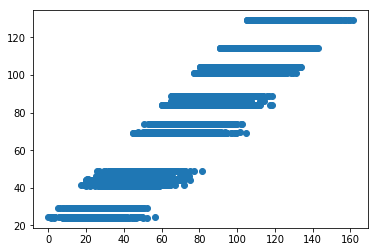

In [19]:
predictions=sklmodel.predict(X_test)
plt.scatter(Y_test,predictions)

In [27]:
result = sklmodel.score(X_test, Y_test)
print("Accuracy: {}".format(result*100.0))

Accuracy: 91.63616181177707
